## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [2]:
taxi_df = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_df.shape))
taxi_df.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [106]:
# Создании копии Df
taxi_data = taxi_df.copy()

In [107]:
# Преобразование столбца в формат Data Time с часами, минутами, секундами
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
# Создание столбца только с датой, без времени
taxi_data['year_mound_day'] = taxi_data['pickup_datetime'].apply(lambda x: str(x).split(' ')[0])
# Сортировка по столбцу с датой по возрастанию
taxi_data = taxi_data.sort_values(by=['year_mound_day'])
# Вывод на печать разницы в днях от начальной и конечной даты. Чтобы выбрать даты в отcортированном списке по датам беру первую и последнюю запись, определяю их индексы,
# и эти индексы подставляю в разницу по столбцу с данными datetime.
# К разности дат добавляем 1 так как разница не учитывает первый день
print(f"Интервал дат содержащийся в DF от {taxi_data.year_mound_day.head(1).values[0]} до {taxi_data.year_mound_day.tail(1).values[0]}, общей продолжительностью в \
{int(str(taxi_data['pickup_datetime'][taxi_data.year_mound_day.tail(1).index.values[0]] - taxi_data['pickup_datetime'][taxi_data.year_mound_day.head(1).index.values[0]]).split(' ')[0])+ 1} дня")
taxi_data = taxi_data.drop('year_mound_day', axis=1)# Удаление временного столбца с данными
taxi_data.reset_index(drop=True, inplace=True)# Полная переиндексация

Интервал дат содержащийся в DF от 2016-01-01 до 2016-06-30, общей продолжительностью в 182 дня


### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [5]:
(taxi_data.isnull().sum()).sum()

0

Пропусков в данных нет

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [6]:
print(f'Уникальных таксопарков в данных: {taxi_data.vendor_id.nunique()}')
print(f'Максимальное кол-во пассажиров за одну поездку: {taxi_data.passenger_count.max()}')
print(f'Средняя продолжительность поезди в секундах: {round(taxi_data.trip_duration.mean())}')
print(f'Медианная продолжительность поезди в секундах: {round(taxi_data.trip_duration.median())}')
print(f'Минимальное время поезди в секундах: {taxi_data.trip_duration.min()}')
print(f'Максимальное время поезди в секундах: {taxi_data.trip_duration.max()}')

Уникальных таксопарков в данных: 2
Максимальное кол-во пассажиров за одну поездку: 9
Средняя продолжительность поезди в секундах: 959
Медианная продолжительность поезди в секундах: 662
Минимальное время поезди в секундах: 1
Максимальное время поезди в секундах: 3526282


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [5]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek
    return df

In [108]:
add_datetime_features(taxi_data).head(2)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id0752048,1,2016-01-01 01:11:29,2016-01-01 01:16:03,1,-73.963486,40.768528,-73.969521,40.757580,N,274,2016-01-01,1,4
1,id3056049,1,2016-01-01 13:05:31,2016-01-01 13:13:06,1,-73.998032,40.751167,-73.976761,40.751854,N,455,2016-01-01,13,4


In [109]:
print(f'В субботу за указанный период времени было совершено: {taxi_data.pickup_day_of_week.value_counts()[5]} поездок')
print(f'В среднем за день совершается: {round(taxi_data.pickup_date.value_counts().mean())} поездок')

В субботу за указанный период времени было совершено: 220868 поездок
В среднем за день совершается: 8015 поездок


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [7]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
# ваш код здесь

In [110]:
def add_holiday_features(df, df_holiday):
    df_holiday['date'] = pd.to_datetime(df_holiday['date'], format='%Y-%m-%d')#Преобразование столбца в формат DateTime
    df_holiday['date'] = df_holiday['date'].dt.date# Выделение даты
    list_holiday = []#Создание пустого списка для праздничных дней
    for x in holiday_data['date']:
        list_holiday.append(x)#Заполнение списка парздничными датами
    df['pickup_holiday'] = df['pickup_date'].apply(lambda x: 1 if x in list_holiday else 0)#Создание бинарного столбца с значением была ли поездка накчата в прадник
    return df


In [111]:
add_holiday_features(taxi_data, holiday_data).head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday
0,id0752048,1,2016-01-01 01:11:29,2016-01-01 01:16:03,1,-73.963486,40.768528,-73.969521,40.757580,N,274,2016-01-01,1,4,1
1,id3056049,1,2016-01-01 13:05:31,2016-01-01 13:13:06,1,-73.998032,40.751167,-73.976761,40.751854,N,455,2016-01-01,13,4,1


In [112]:
# Проверка на правильность отработки кода с выставлением праздничных дат
taxi_data['pickup_holiday'].value_counts()

pickup_holiday
0    1407522
1      51122
Name: count, dtype: int64

In [113]:
print(f'Медианная длительность поездки на такси в праздничные дни: {round(taxi_data[taxi_data.pickup_holiday == 1].trip_duration.median())} секунд')

Медианная длительность поездки на такси в праздничные дни: 585 секунд


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [11]:
# Открытие файла с данными osrm
osrm_data = pd.read_csv('data/osrm_data_train.csv')

In [114]:
# Объединение на merge
def add_osrm_features(data, osrm_d):
    data = data.merge(osrm_d, on='id', how='left')
    return data

In [116]:
taxi_data = add_osrm_features(taxi_data, osrm_data)

In [117]:
taxi_data.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
0,id0752048,1,2016-01-01 01:11:29,2016-01-01 01:16:03,1,-73.963486,40.768528,-73.969521,40.757580,N,274,2016-01-01,1,4,1,1592.9,164.6,4.0
1,id3056049,1,2016-01-01 13:05:31,2016-01-01 13:13:06,1,-73.998032,40.751167,-73.976761,40.751854,N,455,2016-01-01,13,4,1,2984.5,303.5,7.0


In [118]:
# Подсчёт разницы медианных значений в исходной таблице и osrm
round(taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median())

372

In [119]:
# Пропуски в обновлённой таблице
taxi_data[['total_distance', 'total_travel_time', 'number_of_steps']].isnull().sum()

total_distance       1
total_travel_time    1
number_of_steps      1
dtype: int64

In [14]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [15]:
# Функция принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами 
# haversine_distance - расстояние Хаверсина между точками старта и окончания поездки
# direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.
def add_geographical_features(df):
    df['haversine_distance'] = get_haversine_distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    df['direction'] = get_angle_direction(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    return df

In [120]:
add_geographical_features(taxi_data).head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction
0,id0752048,1,2016-01-01 01:11:29,2016-01-01 01:16:03,1,-73.963486,40.768528,-73.969521,40.757580,N,274,2016-01-01,1,4,1,1592.9,164.6,4.0,1.319222,-157.337366
1,id3056049,1,2016-01-01 13:05:31,2016-01-01 13:13:06,1,-73.998032,40.751167,-73.976761,40.751854,N,455,2016-01-01,13,4,1,2984.5,303.5,7.0,1.793378,87.553002


In [121]:
round(taxi_data['haversine_distance'].median(), 2)

2.09

### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Какое минимальное количество поездок в кластере?


In [122]:
kmeans = cluster.KMeans(n_clusters=10, random_state=42)

def add_cluster_features(data, kmeans):
    # создаем обучающую выборку из географических координат всех точек
    coords = np.hstack((data[['pickup_latitude', 'pickup_longitude']],
                        data[['dropoff_latitude', 'dropoff_longitude']]))
    # обучаем алгоритм кластеризации
    kmeans.fit(coords)
    data['geo_cluster'] = kmeans.predict(coords)
    return data

In [123]:
add_cluster_features(taxi_data, kmeans).head(2)

c:\Users\Major\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster
0,id0752048,1,2016-01-01 01:11:29,2016-01-01 01:16:03,1,-73.963486,40.768528,-73.969521,40.757580,N,...,2016-01-01,1,4,1,1592.9,164.6,4.0,1.319222,-157.337366,8
1,id3056049,1,2016-01-01 13:05:31,2016-01-01 13:13:06,1,-73.998032,40.751167,-73.976761,40.751854,N,...,2016-01-01,13,4,1,2984.5,303.5,7.0,1.793378,87.553002,0


In [124]:
# Какое минимальное количество поездок в кластере?
taxi_data['geo_cluster'].value_counts().min()

2

### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [20]:
weather_data = pd.read_csv("data/weather_data.csv")

In [21]:
def add_weather_features(df, weather):
    weather['date'] = pd.to_datetime(weather['date'])
    weather['date'] = weather['date'].dt.date
    weather = weather[['date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']]

    df = df.merge(weather, 
        how='left', 
        left_on=['pickup_date', 'pickup_hour'],
        right_on=['date', 'hour']
    )
    df = df.drop(['date', 'hour'], axis=1)
    return df

In [125]:
taxi_data = add_weather_features(taxi_data, weather_data)

In [127]:
taxi_data['events'].value_counts()

events
None    1387217
Rain      58300
Snow      13126
Fog           1
Name: count, dtype: int64

In [128]:
taxi_data[['temperature', 'visibility', 'wind speed', 'precip', 'events']].isnull().sum() * 100 / taxi_data.shape[0]

temperature    0.824876
visibility     0.824876
wind speed     0.824876
precip         0.824876
events         0.000000
dtype: float64

### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [27]:
def fill_null_weather_data(df):
    # Замена пропусков на медианное значение по столбцам сгрупиррованым по датам (медианное значение в определённую дату)
    df[['temperature', 'visibility', 'wind speed', 'precip']] = df[['temperature', 'visibility', 'wind speed', 'precip']].fillna(
    df.groupby('pickup_date')[['temperature', 'visibility', 'wind speed', 'precip']].transform('median'))
    df['events'] = df['events'].fillna('None')#Пропусков на "None"
    # Замена пропусков в столбцах на медианное значение по каждому столбцу
    df[['total_distance','total_travel_time', 'number_of_steps']] = df[['total_distance','total_travel_time', 'number_of_steps']].fillna\
        (df[['total_distance','total_travel_time', 'number_of_steps']].median())
    return df

In [129]:
taxi_data = fill_null_weather_data(taxi_data)

In [130]:
taxi_data['temperature'].median()

11.1

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


Text(0, 0.5, 'Average speed')

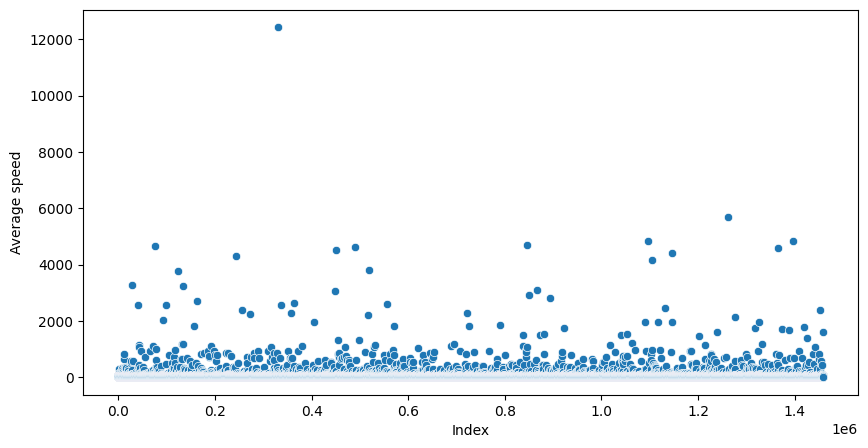

In [73]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed')

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [131]:
print(f'Колличество поездок превышающих по длительности 24 часа: {len(taxi_data[taxi_data.trip_duration / 3600 > 24].index)}')#Подсчёт количества поездок превышающих по длительности 24 часа
taxi_data.drop(index=(taxi_data[taxi_data['trip_duration']/3600 > 24].index), inplace=True)# Удаление строк с поездками превышающих по длительности 24 часа
taxi_data['avg_speed'] = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6 # Создание столбца со скоростью передвижения такси
print(f'Количество поездок со скоростью передвижения такси более 300 км: {len(taxi_data[taxi_data.avg_speed > 300].index)}')
taxi_data.drop(index=(taxi_data[taxi_data.avg_speed > 300].index), inplace=True)# Удаление строк с поездками превышающих по скорости 300 км
taxi_data.drop('avg_speed', axis=1, inplace=True)# Удаление временного столбца со скоростью

Колличество поездок превышающих по длительности 24 часа: 4
Количество поездок со скоростью передвижения такси более 300 км: 407


Text(0, 0.5, 'Average speed')

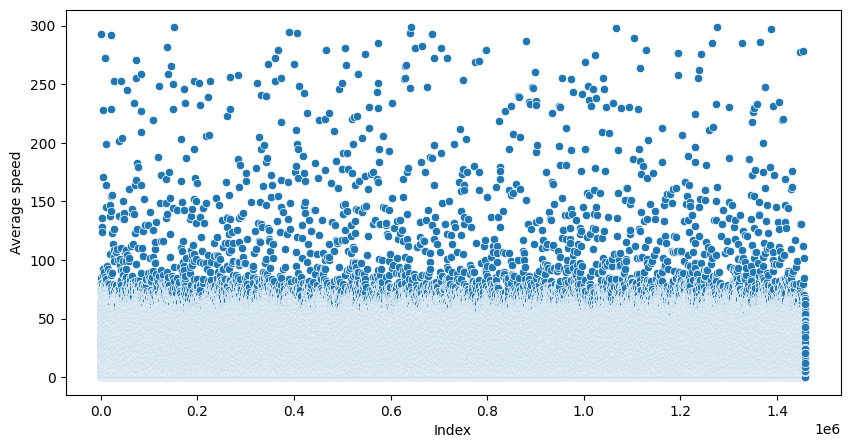

In [59]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed')

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [132]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

Text(0.5, 0, 'Распределение длительности поездок')

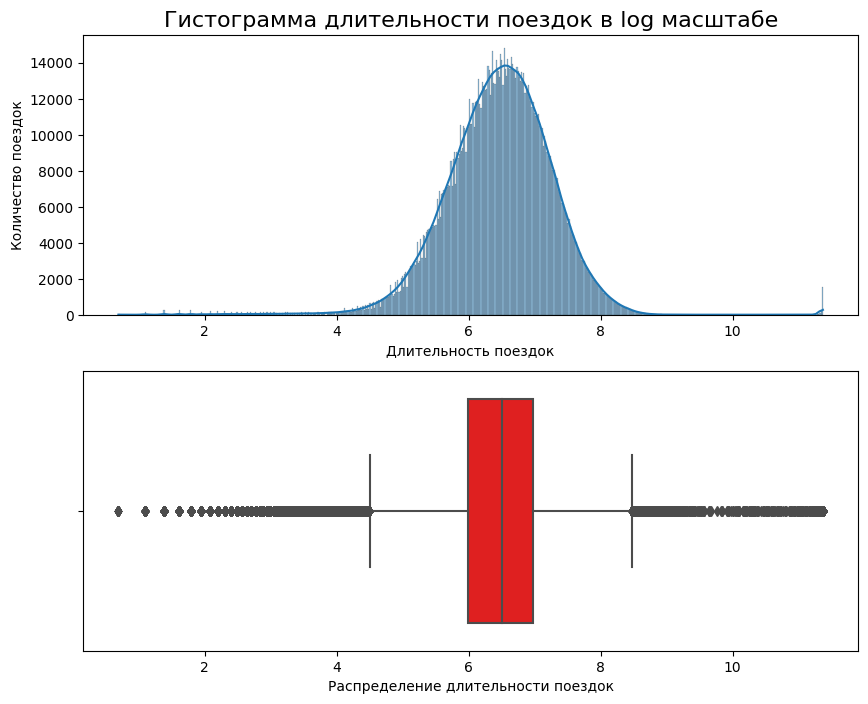

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.histplot(
    data=taxi_data,
    x='trip_duration_log',
    kde=True,
    ax=axes[0]
)
axes[0].set_title('Гистограмма длительности поездок в log масштабе', fontsize=16)
axes[0].set_xlabel('Длительность поездок')
axes[0].set_ylabel('Количество поездок')
sns.boxplot(
    data=taxi_data,
    x='trip_duration_log',
    color='red',
    ax=axes[1]
)
axes[1].set_xlabel('Распределение длительности поездок')

Нулевая гипотеза гласит, что данный распределены нормально. Что будет подтверждено если p-value будет больше alpha

In [63]:
from scipy.stats import normaltest
# задаём уровень значимости
alpha = 0.05 

# загружаем данные
data = taxi_data['trip_duration_log']

# проводим тест
_, p = normaltest(data)

print('p-value = {:.2f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение не нормальное.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение не нормальное.'.format(alpha))

p-value = 0.00
p-значение меньше, чем заданный уровень значимости 0.05. Распределение не нормальное.


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

Text(0.5, 0, 'Распределение длительности поездок для второго таксопарка')

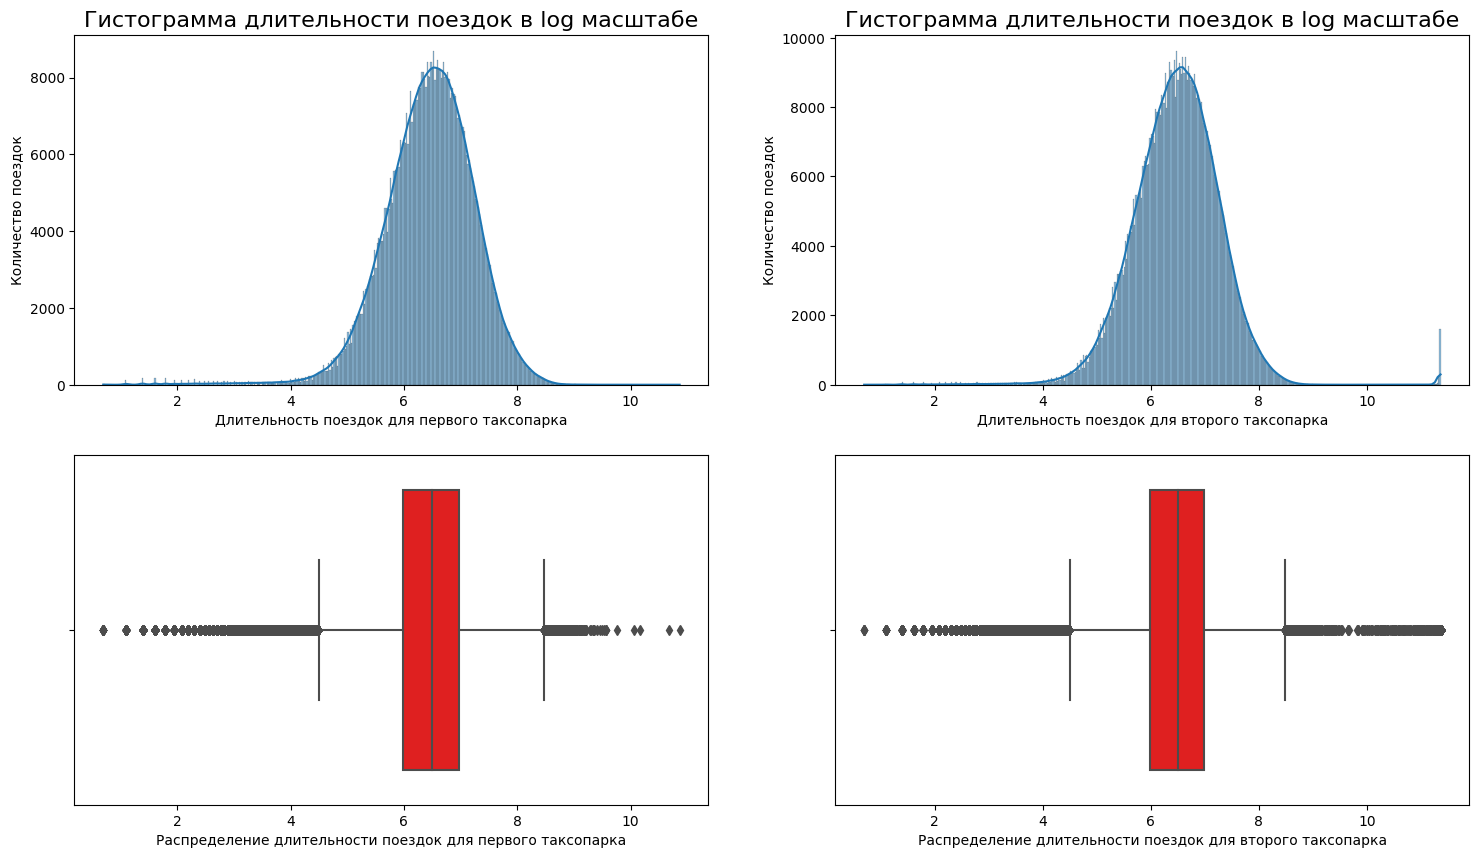

In [82]:
taxi_vendor_1 = taxi_data[taxi_data['vendor_id'] == 1]
taxi_vendor_2 = taxi_data[taxi_data['vendor_id'] == 2]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
sns.histplot(
    data=taxi_vendor_1,
    x='trip_duration_log',
    kde=True,
    ax=axes[0, 0]
)
axes[0, 0].set_title('Гистограмма длительности поездок в log масштабе', fontsize=16)
axes[0, 0].set_xlabel('Длительность поездок для первого таксопарка')
axes[0, 0].set_ylabel('Количество поездок')

sns.boxplot(
    data=taxi_vendor_1,
    x='trip_duration_log',
    color='red',
    ax=axes[1, 0]
)
axes[1, 0].set_xlabel('Распределение длительности поездок для первого таксопарка')

sns.histplot(
    data=taxi_vendor_2,
    x='trip_duration_log',
    kde=True,
    ax=axes[0, 1]
)
axes[0, 1].set_title('Гистограмма длительности поездок в log масштабе', fontsize=16)
axes[0, 1].set_xlabel('Длительность поездок для второго таксопарка')
axes[0, 1].set_ylabel('Количество поездок')

sns.boxplot(
    data=taxi_vendor_2,
    x='trip_duration_log',
    color='red',
    ax=axes[1, 1]
)
axes[1, 1].set_xlabel('Распределение длительности поездок для второго таксопарка')

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

In [134]:
taxi_data['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    1450192
Y       8041
Name: count, dtype: int64

Text(0.5, 0, 'Распределение длительности поездок при отправке сообщения')

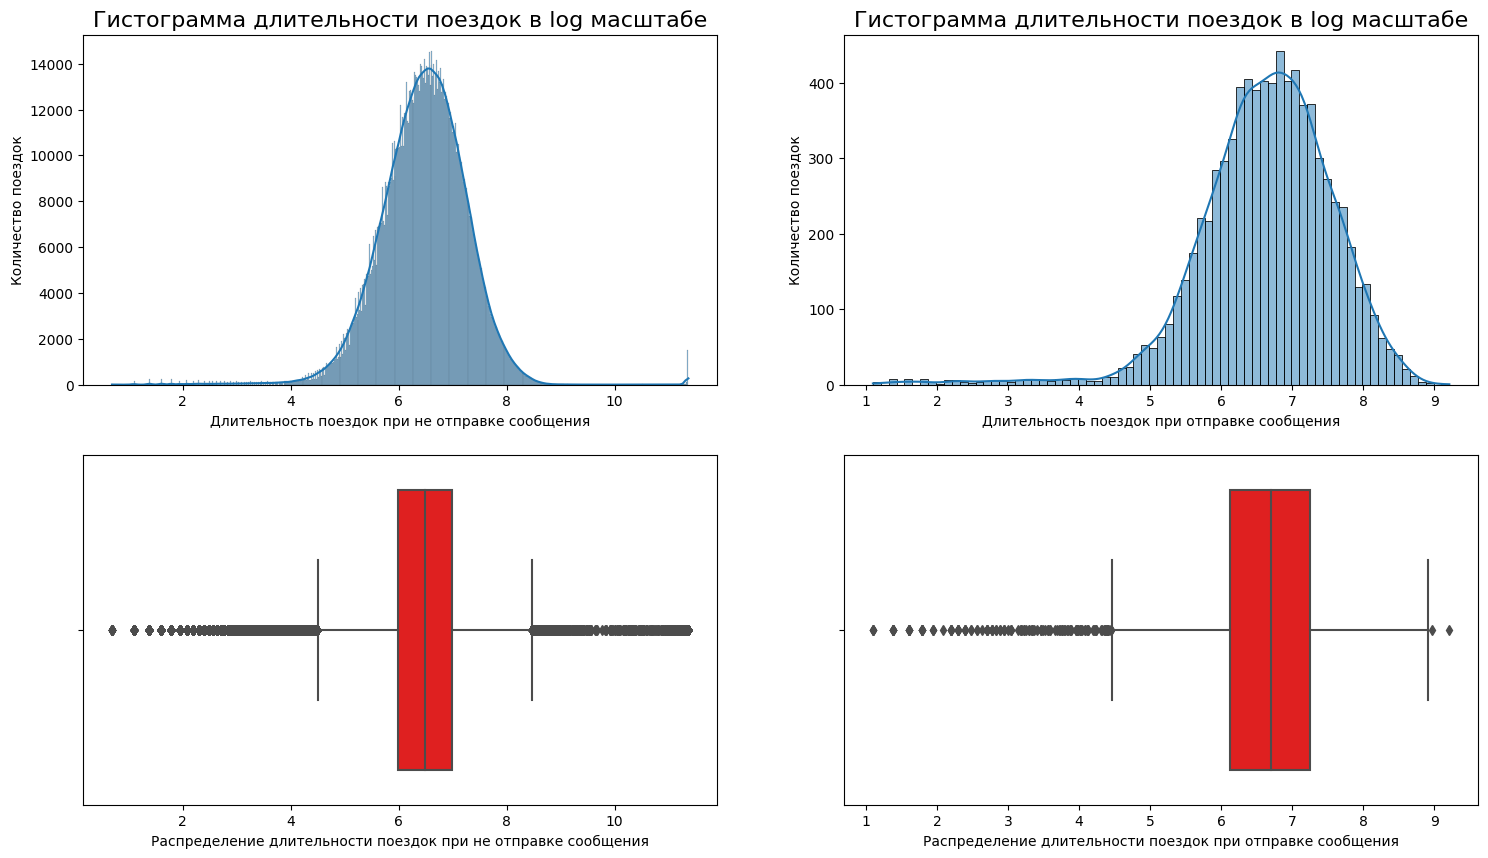

In [66]:
taxi_flag_n = taxi_data[taxi_data['store_and_fwd_flag'] == 'N']
taxi_flag_y = taxi_data[taxi_data['store_and_fwd_flag'] == 'Y']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
sns.histplot(
    data=taxi_flag_n,
    x='trip_duration_log',
    kde=True,
    ax=axes[0, 0]
)
axes[0, 0].set_title('Гистограмма длительности поездок в log масштабе', fontsize=16)
axes[0, 0].set_xlabel('Длительность поездок при не отправке сообщения')
axes[0, 0].set_ylabel('Количество поездок')

sns.boxplot(
    data=taxi_flag_n,
    x='trip_duration_log',
    color='red',
    ax=axes[1, 0]
)
axes[1, 0].set_xlabel('Распределение длительности поездок при не отправке сообщения')

sns.histplot(
    data=taxi_flag_y,
    x='trip_duration_log',
    kde=True,
    ax=axes[0, 1]
)
axes[0, 1].set_title('Гистограмма длительности поездок в log масштабе', fontsize=16)
axes[0, 1].set_xlabel('Длительность поездок при отправке сообщения')
axes[0, 1].set_ylabel('Количество поездок')

sns.boxplot(
    data=taxi_flag_y,
    x='trip_duration_log',
    color='red',
    ax=axes[1, 1]
)
axes[1, 1].set_xlabel('Распределение длительности поездок при отправке сообщения')

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

Text(0, 0.5, 'Медианная длительность поездок')

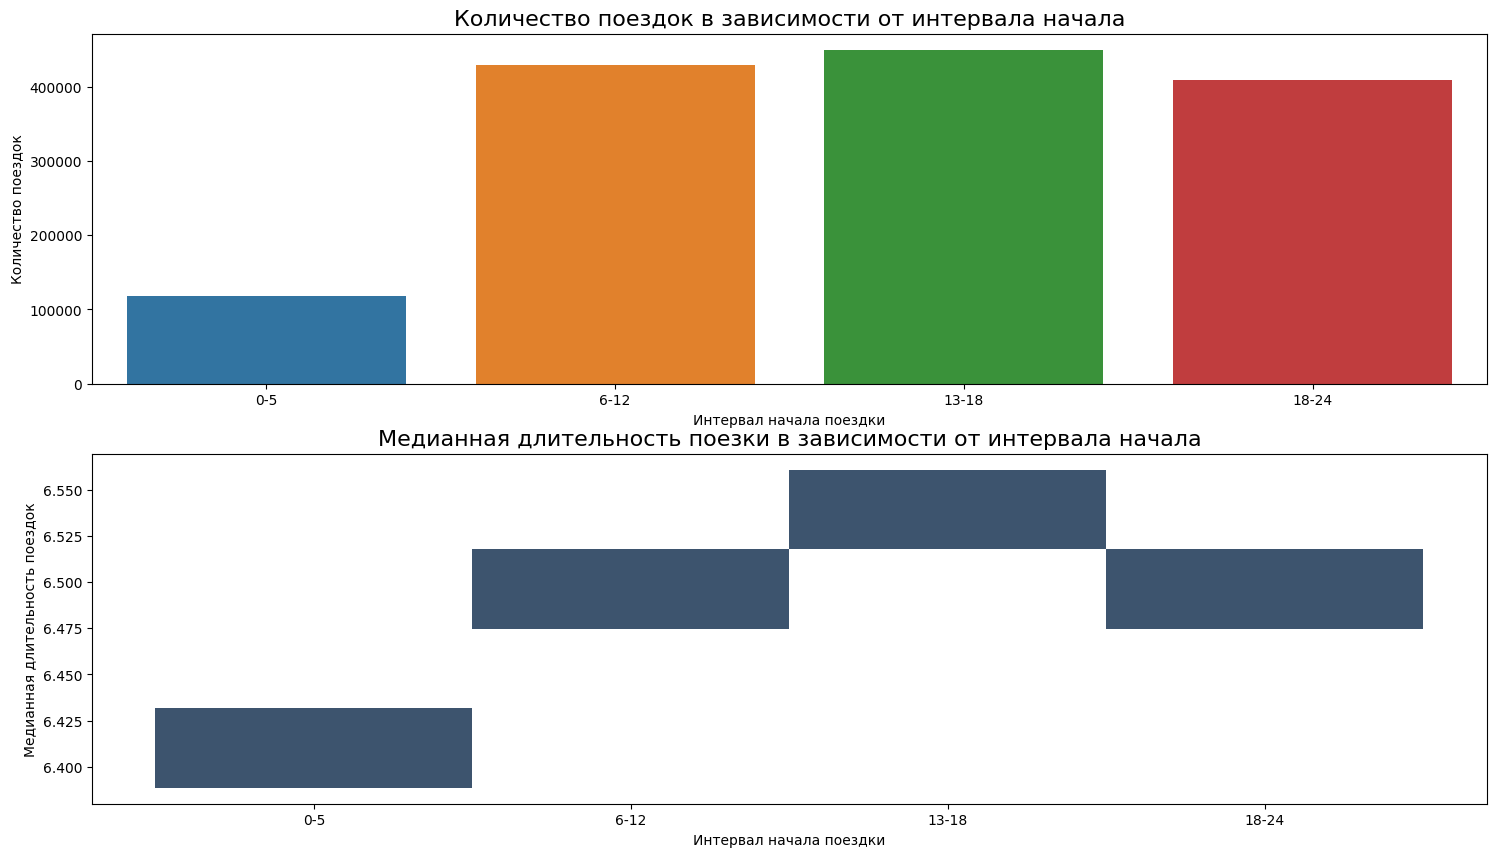

In [67]:
taxi_int_hour = taxi_data.copy()#Делаю копию DF чтобы не добавлять в исходник лишних столбцов
taxi_int_hour['int_hour'] = pd.cut(taxi_int_hour.pickup_hour, [0, 5, 12, 18, 23], labels=['0-5', '6-12', '13-18', '18-24'])# Группировка по интервалам по столбцу час начала поездки
taxi_median = taxi_int_hour.groupby('int_hour')[['trip_duration_log']].median().nlargest(4, columns=['trip_duration_log'])# Подсчёт медианнной длительности поездки по интервалу времени

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 10))
sns.countplot(
    data=taxi_int_hour,
    x='int_hour',
    ax=axes[0]
)
axes[0].set_title('Количество поездок в зависимости от интервала начала', fontsize=16)
axes[0].set_xlabel('Интервал начала поездки')
axes[0].set_ylabel('Количество поездок')

sns.histplot(
    data=taxi_median,
    x='int_hour',
    y='trip_duration_log',
    ax=axes[1]
)
axes[1].set_title('Медианная длительность поезки в зависимости от интервала начала', fontsize=16)
axes[1].set_xlabel('Интервал начала поездки')
axes[1].set_ylabel('Медианная длительность поездок')

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


Text(0, 0.5, 'Медианная длительность поездок')

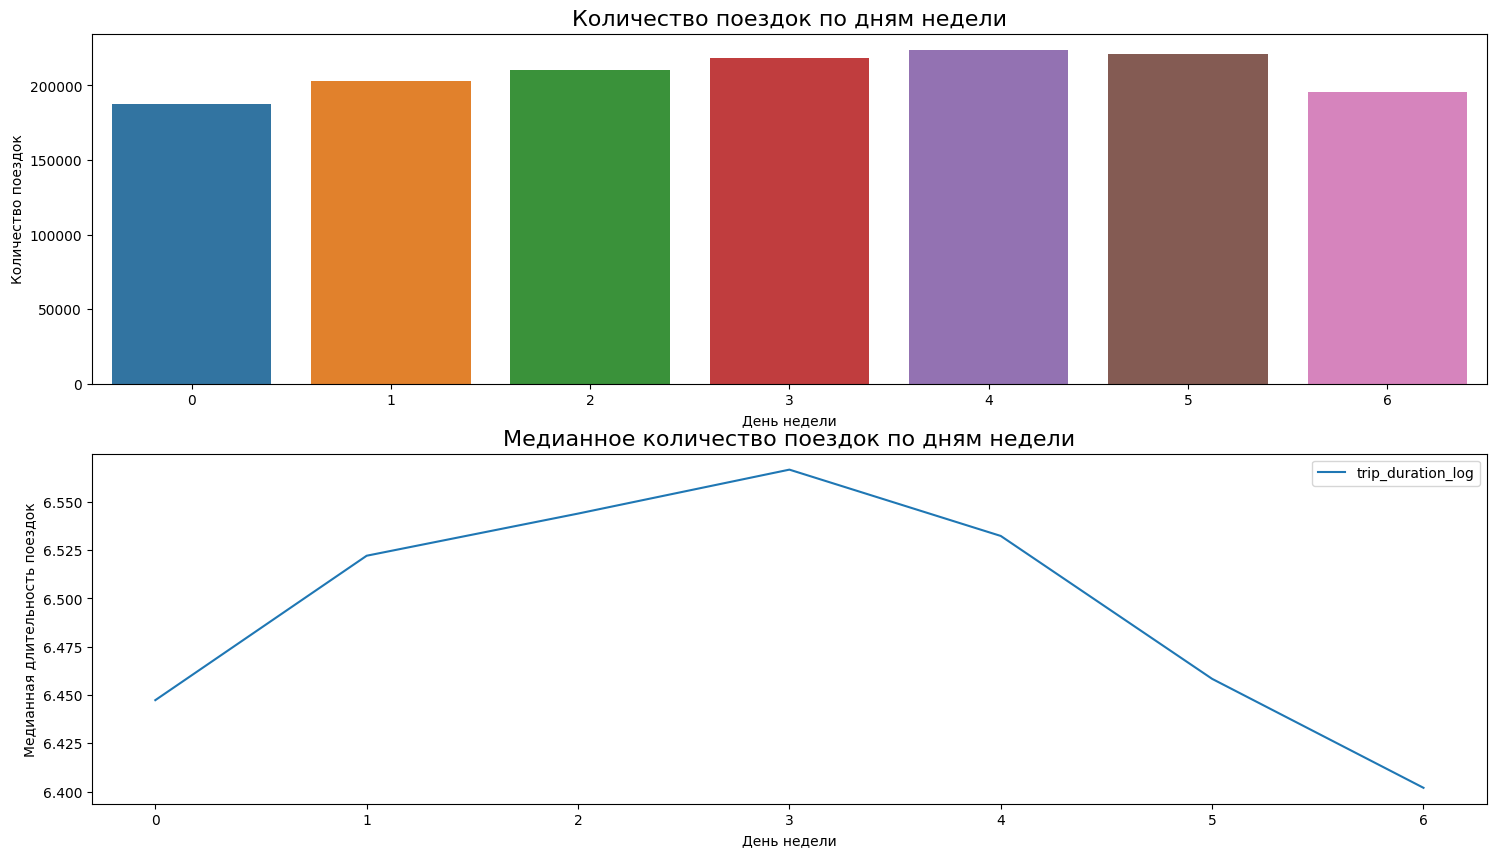

In [68]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 10))
sns.countplot(
    data=taxi_data,
    x='pickup_day_of_week',
    ax=axes[0]
)
axes[0].set_title('Количество поездок по дням недели', fontsize=16)
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Количество поездок')

taxi_data.groupby('pickup_day_of_week')['trip_duration_log'].median().plot(legend=True)# Вариант построения грайика сразу на данных groupby
axes[1].set_title('Медианное количество поездок по дням недели', fontsize=16)
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Медианная длительность поездок')

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

In [32]:
# Для того, чтобы финальный результат был представлен в виде сводной таблицы (первый группировочный признак по строкам, а второй — по столбцам), а не в виде Series с иерархическими индексами, 
# к результату чаще всего применяют метод unstack(), который позволяет переопределить вложенный индекс в виде столбцов таблицы:
pickup_hour_weeek = taxi_data.groupby(['pickup_hour', 'pickup_day_of_week'])['trip_duration'].median().unstack()
pickup_hour_weeek

pickup_day_of_week,0,1,2,3,4,5,6
pickup_hour,,,,,,,
0,598.0,591.0,601.0,609.0,649.0,685.0,675.0
1,567.0,584.0,553.0,564.0,600.0,640.0,643.0
2,565.0,565.0,544.0,576.0,572.0,610.0,604.5
3,600.0,568.0,574.0,584.0,578.0,591.0,608.0
4,640.0,600.5,616.0,595.0,634.0,610.0,598.5
5,519.0,455.0,448.0,480.0,532.0,631.0,634.0
6,462.0,461.0,463.0,471.0,476.0,508.0,554.0
7,575.0,586.0,593.0,599.0,578.0,481.0,474.0
8,672.0,703.0,704.0,721.0,689.0,489.0,460.0


Text(-29.27777777777778, 0.5, 'Количество поездок')

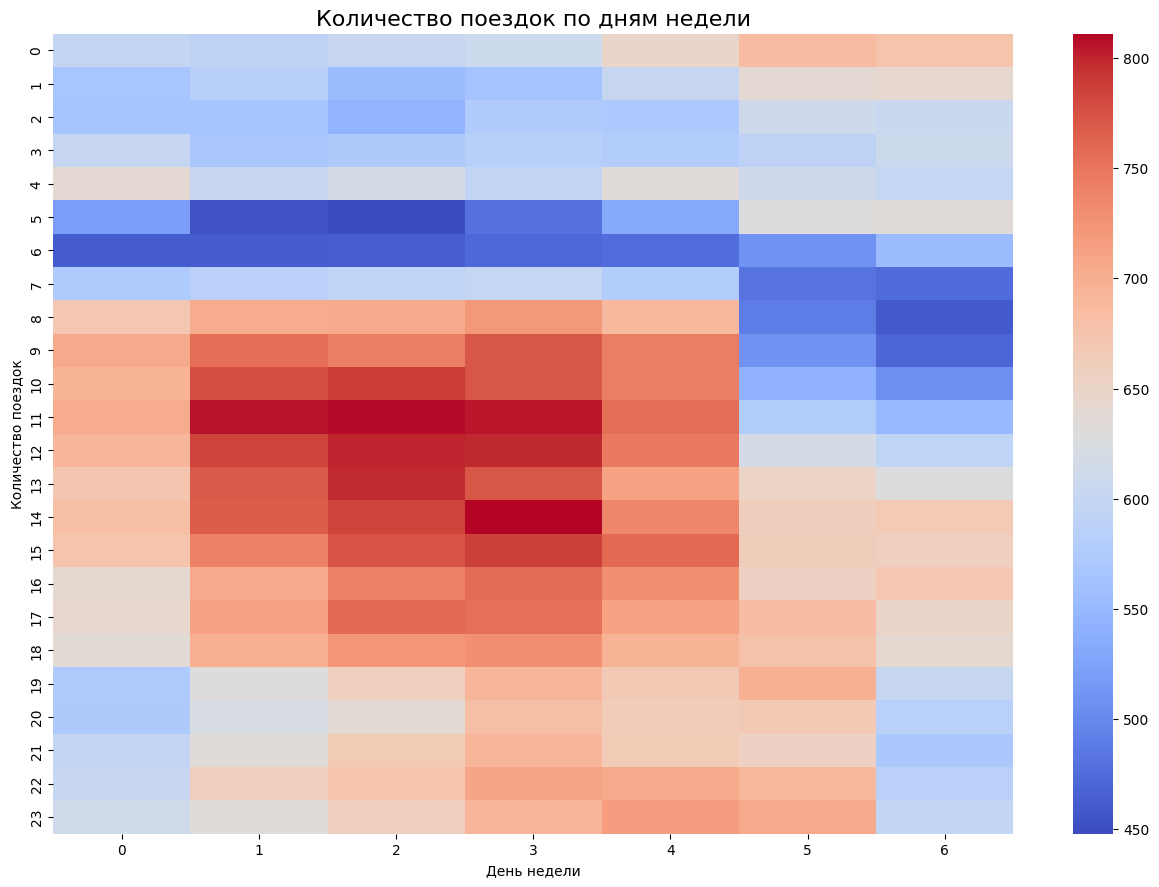

In [70]:
fig = plt.figure(figsize=(12, 8))
axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(
    data=pickup_hour_weeek,
    cmap='coolwarm',
    ax=axes
)
axes.set_title('Количество поездок по дням недели', fontsize=16)
axes.set_xlabel('День недели')
axes.set_ylabel('Количество поездок')

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


In [27]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

In [79]:
# Фильтрация данных по заданным диапвзонам
long_mask_pickup = taxi_data['pickup_longitude'].between(-74.03, -73.75, inclusive='both')# границы и inclusive включать или нет границы в диапазон. both - включать обе
long_mask_dropoff = taxi_data['dropoff_longitude'].between(-74.03, -73.75, inclusive='both')# neither не включать
lat_mask_pickup = taxi_data['pickup_latitude'].between(40.63, 40.85, inclusive='both') # left левую включать
lat_mask_dropoff = taxi_data['dropoff_latitude'].between(40.63, 40.85, inclusive='both') # right правую включать
taxi_new_york = taxi_data[(long_mask_pickup & long_mask_dropoff) & (lat_mask_pickup & lat_mask_dropoff)]

Text(0, 0.5, 'широта')

C:\Users\Major\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Major\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


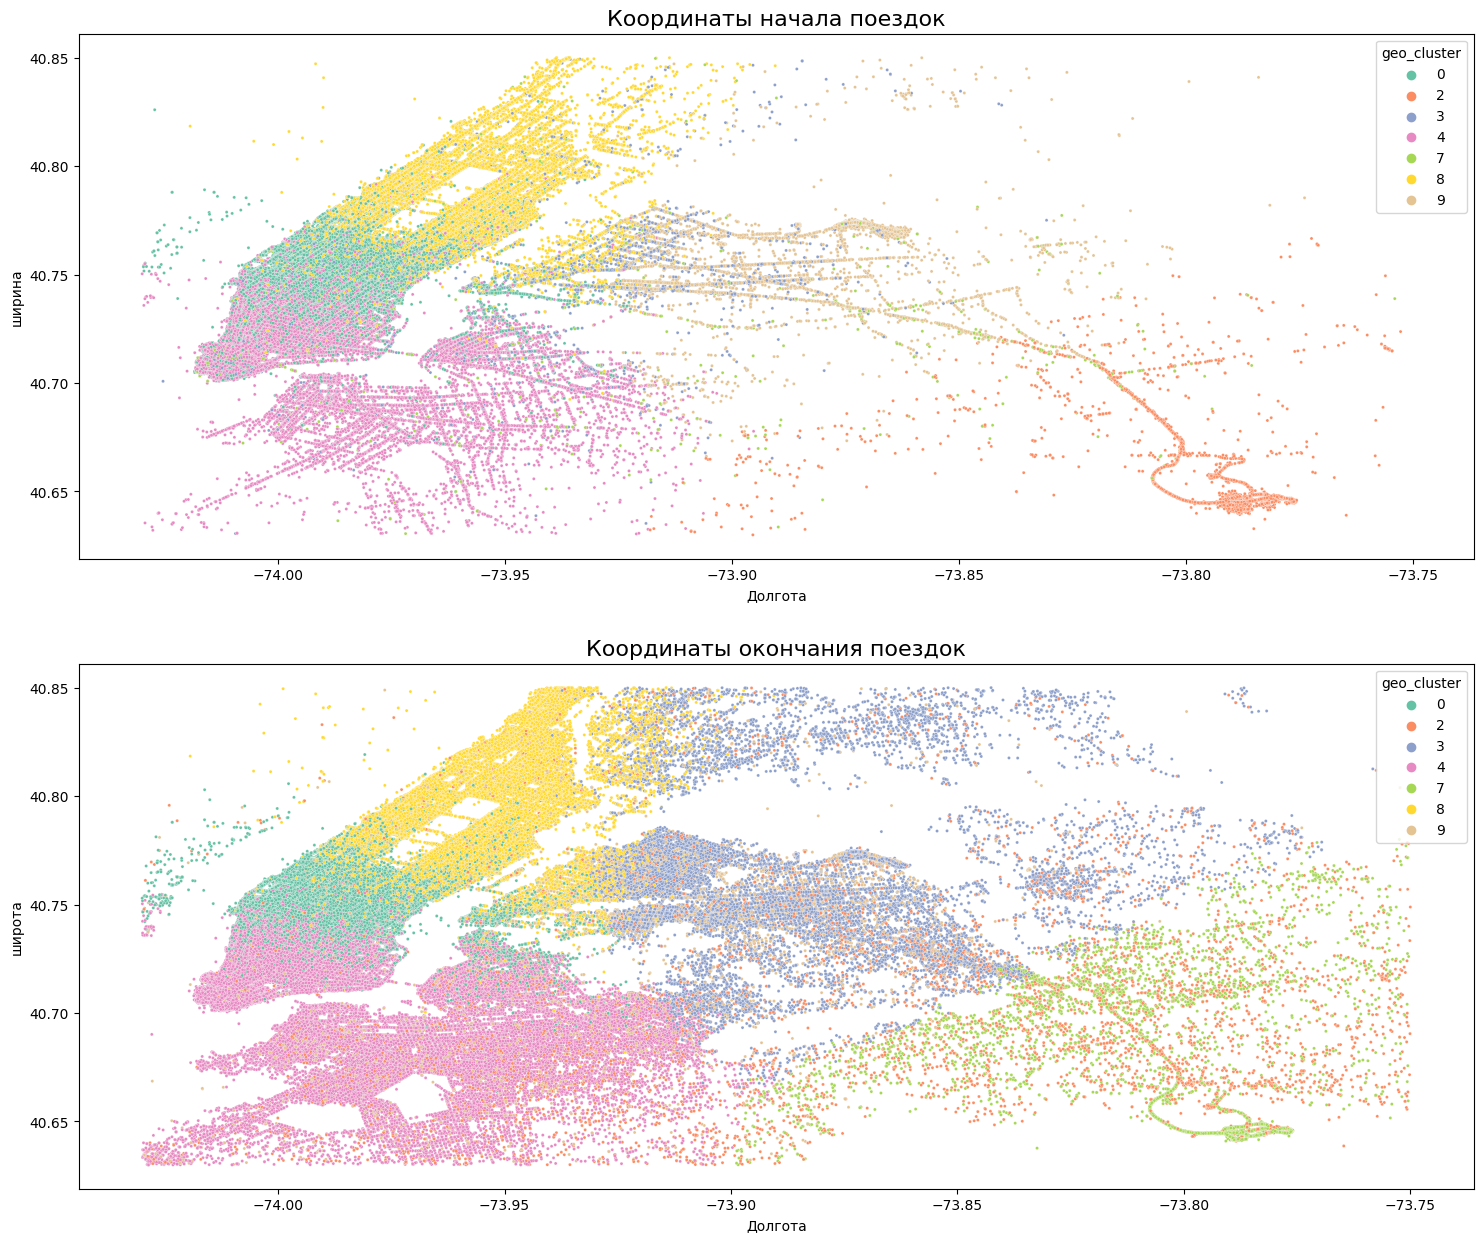

In [80]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 15))
sns.scatterplot(
    data=taxi_new_york,
    x ='pickup_longitude',
    y ='pickup_latitude' ,
    hue = 'geo_cluster',
    palette="Set2",
    s=5,
    ax=axes[0]
)
axes[0].set_title('Координаты начала поездок', fontsize=16)
axes[0].set_xlabel('Долгота')
axes[0].set_ylabel('ширина')

sns.scatterplot(
    data=taxi_new_york,
    x ='dropoff_longitude',
    y ='dropoff_latitude',
    hue = 'geo_cluster',
    palette="Set2",
    s=5,
    ax=axes[1]
)
axes[1].set_title('Координаты окончания поездок', fontsize=16)
axes[1].set_xlabel('Долгота')
axes[1].set_ylabel('широта')

In [73]:
taxi_data['geo_cluster'].nunique() - taxi_new_york['geo_cluster'].nunique()

3

Text(0, 0.5, 'Количество поездок')

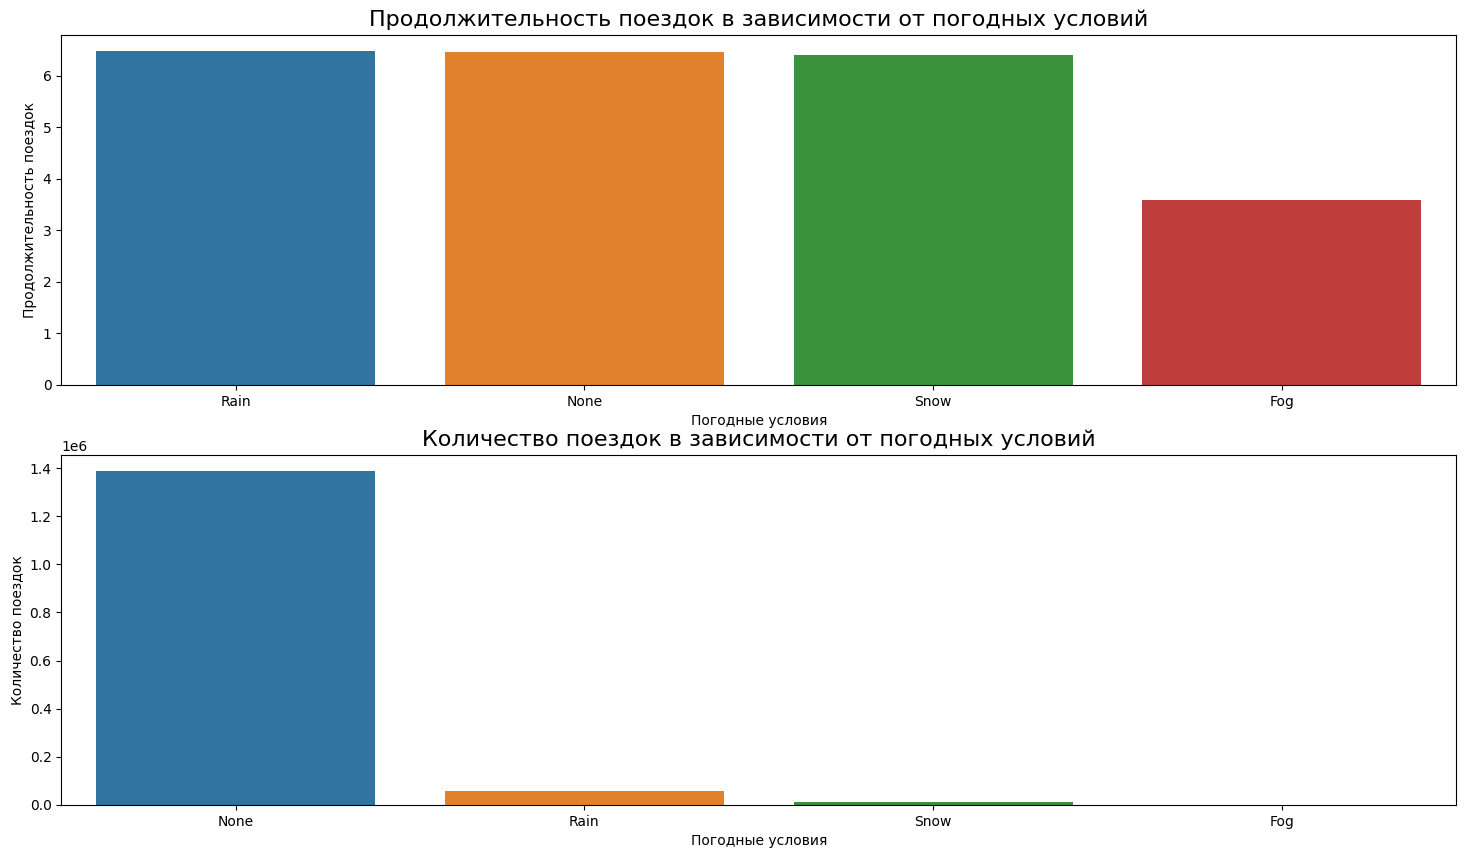

In [81]:
# Поиск новых закономерностей влияющих на продолжительность поездки
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 10))

taxi_events_trip = taxi_data.groupby('events')[['trip_duration_log']].mean().nlargest(4, columns=['trip_duration_log'])# Подсчёт медианнной длительности поездки по интервалу времени
taxi_events_count = taxi_data.groupby('events')[['trip_duration_log']].count().nlargest(4, columns=['trip_duration_log'])# Подсчёт медианнной длительности поездки по интервалу времени
sns.barplot(
    data=taxi_events_trip,
    x=taxi_events_trip.index,
    y='trip_duration_log',
    ax=axes[0]
)
axes[0].set_title('Продолжительность поездок в зависимости от погодных условий', fontsize=16)
axes[0].set_xlabel('Погодные условия')
axes[0].set_ylabel('Продолжительность поездок')

sns.barplot(
    data=taxi_events_count,
    x=taxi_events_count.index,
    y='trip_duration_log',
    ax=axes[1]
    )
axes[1].set_title('Количество поездок в зависимости от погодных условий', fontsize=16)
axes[1].set_xlabel('Погодные условия')
axes[1].set_ylabel('Количество поездок')

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [135]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


In [136]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id0752048,1,2016-01-01 01:11:29,2016-01-01 01:16:03,1,-73.963486,40.768528,-73.969521,40.757580,N,...,4.0,1.319222,-157.337366,8,5.6,16.1,7.4,0.0,None,5.616771
1,id3056049,1,2016-01-01 13:05:31,2016-01-01 13:13:06,1,-73.998032,40.751167,-73.976761,40.751854,N,...,7.0,1.793378,87.553002,0,4.4,16.1,14.8,0.0,None,6.122493
2,id2365766,1,2016-01-01 15:25:38,2016-01-01 15:43:28,1,-74.005302,40.728542,-73.978622,40.764221,N,...,7.0,4.559729,29.523883,0,4.4,16.1,11.1,0.0,None,6.976348
3,id3938094,2,2016-01-01 08:37:27,2016-01-01 08:44:20,1,-73.977592,40.632847,-73.977592,40.632847,N,...,2.0,0.000000,0.000000,4,3.9,16.1,0.0,0.0,None,6.025866
4,id2777099,2,2016-01-01 12:44:13,2016-01-01 12:53:13,2,-73.956978,40.770802,-73.979050,40.785332,N,...,10.0,2.462602,-48.990637,8,4.4,16.1,9.3,0.0,None,6.293419


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?
* id

б) Утечка данных (data leak) - это 
* ситуация, в которой данные используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной, но эти данные недоступны в реальных условиях.

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?
* dropoff_datetime

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?
* 25


In [137]:
train_data.drop(['id', 'dropoff_datetime'], axis=1, inplace=True)

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [138]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [139]:
# Кодирование бинарных признаков
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

In [140]:
print(f'Среднее знаяение по столбцу vendor_id: {train_data.vendor_id.mean():.2f}')
print(f'Среднее значение по столбцу store_and_fwd_flag: {train_data.store_and_fwd_flag.mean():.3f}')

Среднее знаяение по столбцу vendor_id: 0.53
Среднее значение по столбцу store_and_fwd_flag: 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков  в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [141]:
# OneHot Кодирование
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(drop='first')
X = taxi_data[['pickup_day_of_week', 'geo_cluster', 'events']]
data_onehot = one_hot.fit_transform(X)

In [142]:
# Получаем закодированные имена столбцов
column_names = one_hot.get_feature_names_out()
column_names

array(['pickup_day_of_week_1', 'pickup_day_of_week_2',
       'pickup_day_of_week_3', 'pickup_day_of_week_4',
       'pickup_day_of_week_5', 'pickup_day_of_week_6', 'geo_cluster_1',
       'geo_cluster_2', 'geo_cluster_3', 'geo_cluster_4', 'geo_cluster_5',
       'geo_cluster_6', 'geo_cluster_7', 'geo_cluster_8', 'geo_cluster_9',
       'events_None', 'events_Rain', 'events_Snow'], dtype=object)

In [143]:
# Преобразование sparse matrix of type '<class 'numpy.float64' полученной после OneHotEncoder в DF
data_onehot = pd.DataFrame(data_onehot.toarray(), columns=column_names)

In [144]:
data_onehot.head(5)

,pickup_day_of_week_1,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [145]:
print(f'Таблица с закодированными признаками содержит: {data_onehot.shape[1]} столбцов (признаков)')

Таблица с закодированными признаками содержит: 18 столбцов (признаков)


Добавим полученную таблицу с закодированными признаками:

In [146]:
# Добавление новой таблицы в старую с переиндексацией, с удалением исходных столбцов (которые кодировались)
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(['pickup_day_of_week', 'geo_cluster', 'events'], axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [148]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [149]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [150]:
# Отбор лучших скореллированных данных к целевой переменной
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)
 
best_features = selector.get_feature_names_out()
list(best_features)

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'pickup_hour',
 'pickup_holiday',
 'total_distance',
 'total_travel_time',
 'number_of_steps',
 'haversine_distance',
 'temperature',
 'pickup_day_of_week_1',
 'pickup_day_of_week_2',
 'pickup_day_of_week_3',
 'pickup_day_of_week_4',
 'pickup_day_of_week_5',
 'pickup_day_of_week_6',
 'geo_cluster_2',
 'geo_cluster_3',
 'geo_cluster_7',
 'geo_cluster_8',
 'geo_cluster_9']

In [151]:
# Создание списка столбцов которые надо удалить и удаление и выборок train и valid
columns_drop = []
for x in X_train.columns:
    if x not in list(best_features):
        columns_drop.append(x)
X_train.drop(columns_drop, axis=1, inplace=True)
X_valid.drop(columns_drop, axis=1, inplace=True)
print(f'Колонки X_train: {X_train.shape[1]},\nКолонки X_valid: {X_valid.shape[1]}')

Колонки X_train: 25,
Колонки X_valid: 25


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [152]:
min_max = preprocessing.MinMaxScaler()
min_max.fit(X_train)
X_train = min_max.transform(X_train)
X_valid = min_max.transform(X_valid)

In [153]:
# среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.
round(X_valid[:,0].mean(), 2)

0.54

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



In [154]:
# Преобразование матрицы в DF
X_train = pd.DataFrame(X_train, columns=list(best_features))
# X_train.info()

In [155]:
# Преобразование матрицы в DF
X_valid = pd.DataFrame(X_valid, columns=list(best_features))
# X_valid.info()

### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [156]:
#Создаём объект класса LinearRegression
lr_taxi = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_taxi.fit(X_train, y_train_log)
y_predict_log = lr_taxi.predict(X_train)
y_predict_val_log = lr_taxi.predict(X_valid)
#Рассчитываем RMSE
print('RMSE на тренировочных данных: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_predict_log))))
print('RMSE на валидационных данных: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_predict_val_log))))

RMSE на тренировочных данных: 0.54
RMSE на валидационных данных: 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [14]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_valid_poly = poly.transform(X_valid)
#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_valid_poly.shape)

(977016, 350)
(481217, 350)


In [15]:
#Создаём объект класса LinearRegression
lr_taxi_poly = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_taxi_poly.fit(X_train_poly, y_train_log)
y_predict_log_poly = lr_taxi_poly.predict(X_train_poly)
y_predict_val_log_poly = lr_taxi_poly.predict(X_valid_poly)
#Рассчитываем RMSE
print('RMSLE на тренировочных данных: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_predict_log_poly))))
print('RMSLE на валидационных данных: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_predict_val_log_poly))))

RMSLE на тренировочных данных: 0.47
RMSLE на валидационных данных: 1.87


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [18]:
#Создаём объект класса LinearRegression
lr_taxi_poly_l2 = linear_model.Ridge(alpha=1)
#Обучаем модель — ищем параметры по МНК
lr_taxi_poly_l2.fit(X_train_poly, y_train_log)
y_predict_log_poly_l2 = lr_taxi_poly_l2.predict(X_train_poly)
y_predict_val_log_poly_l2 = lr_taxi_poly_l2.predict(X_valid_poly)
#Рассчитываем RMSE
print('RMSLE на тренировочных данных: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_predict_log_poly_l2))))
print('RMSLE на валидационных данных: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_predict_val_log_poly_l2))))

RMSLE на тренировочных данных: 0.48
RMSLE на валидационных данных: 0.48


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [19]:
#Создаём объект класса DecisionTreeRegressor
taxi_tree = tree.DecisionTreeRegressor()
#Обучаем дерево решений для регрессии
taxi_tree.fit(X_train, y_train_log)
y_predict_log_tree = taxi_tree.predict(X_train)
y_predict_val_log_tree = taxi_tree.predict(X_valid)
#Рассчитываем RMSLE
print('RMSLE на тренировочных данных: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_predict_log_tree))))
print('RMSLE на валидационных данных: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_predict_val_log_tree))))

RMSLE на тренировочных данных: 0.00
RMSLE на валидационных данных: 0.57


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


Text(0, 0.5, 'Значение метрики')

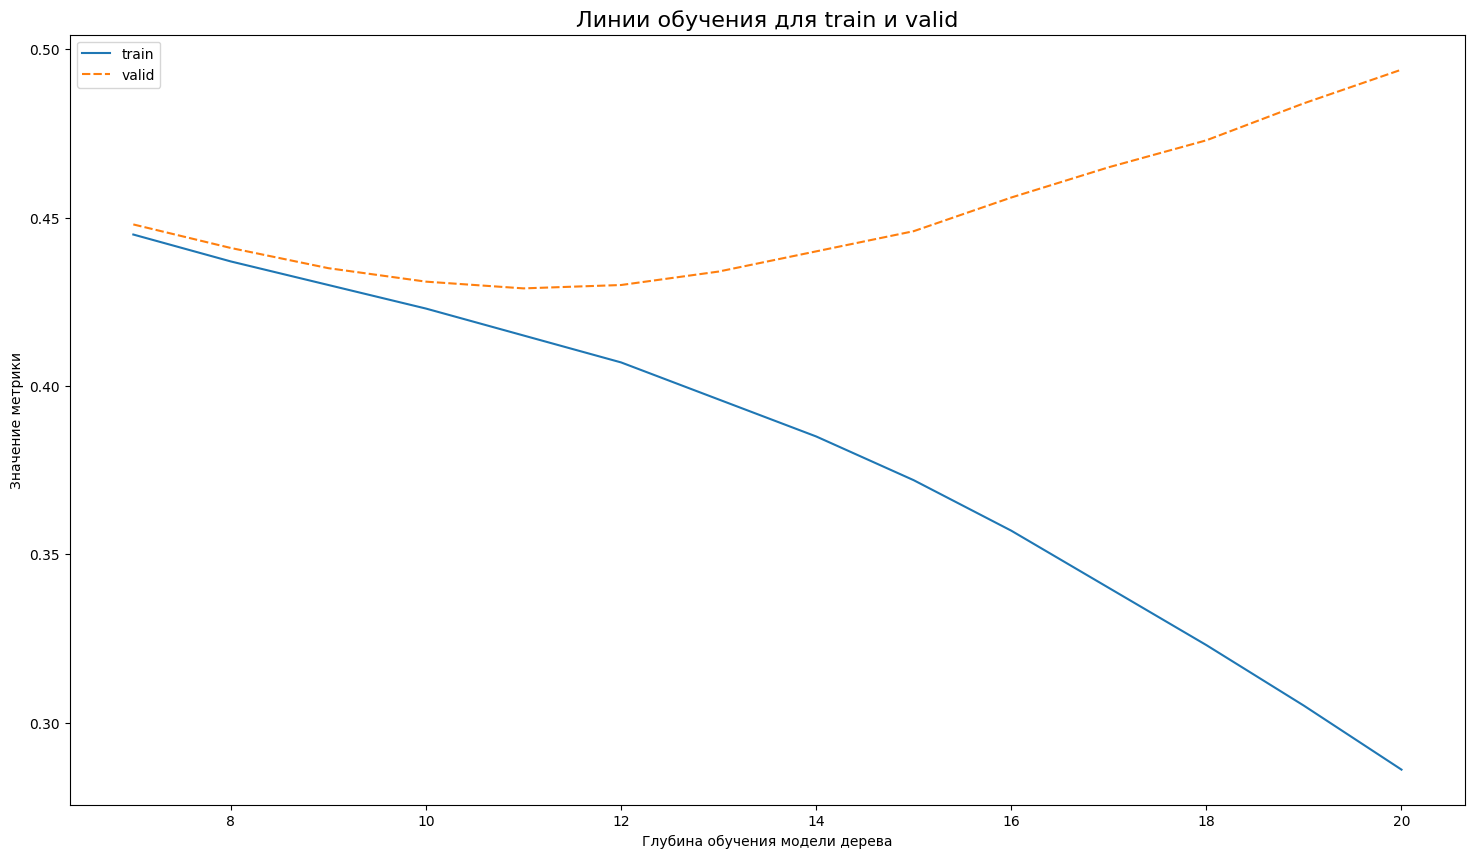

In [64]:
list_x = []
list_train = []
list_valid = []
for x in range(7, 21):
    #Создаём объект класса DecisionTreeRegressor
    taxi_tree = tree.DecisionTreeRegressor(max_depth=x,
                                           random_state=42)
    #Обучаем дерево решений для регрессии
    taxi_tree.fit(X_train, y_train_log)
    y_predict_log_tree = taxi_tree.predict(X_train)
    y_predict_val_log_tree = taxi_tree.predict(X_valid)
    #Рассчитываем RMSLE
    list_x.append(x)
    list_train.append(round((np.sqrt(metrics.mean_squared_error(y_train_log, y_predict_log_tree))), 3))
    list_valid.append(round((np.sqrt(metrics.mean_squared_error(y_valid_log, y_predict_val_log_tree))), 3))

df_curve = pd.DataFrame({'train': list_train, 
                         'valid': list_valid}, index=list_x)


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))
sns.lineplot(
    data=df_curve,
)
axes.legend()
axes.set_title('Линии обучения для train и valid', fontsize=16)
axes.set_xlabel('Глубина обучения модели дерева')
axes.set_ylabel('Значение метрики')


In [63]:
#Создаём объект класса DecisionTreeRegressor
# Согласно графика задаю оптимальную глубину дерева для поиска метрики
taxi_tree = tree.DecisionTreeRegressor(max_depth=12,
                                           random_state=42)
#Обучаем дерево решений для регрессии
taxi_tree.fit(X_train, y_train_log)
y_predict_log_tree = taxi_tree.predict(X_train)
y_predict_val_log_tree = taxi_tree.predict(X_valid)
#Рассчитываем RMSLE
print('RMSLE на тренировочных данных: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_predict_log_tree))))
print('RMSLE на валидационных данных: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_predict_val_log_tree))))

RMSLE на тренировочных данных: 0.41
RMSLE на валидационных данных: 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [66]:
#Создаём объект класса RandomForestRegressor
rf_clf_taxi = ensemble.RandomForestRegressor(
    n_estimators=200, #число деревьев
    criterion='squared_error', #критерий эффективности
    max_depth=12, #максимальная глубина дерева
    min_samples_split=20, #минимальное количество объектов в листе
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_taxi.fit(X_train, y_train_log)
y_predict_log_forest = rf_clf_taxi.predict(X_train)
y_predict_val_log_forest = rf_clf_taxi.predict(X_valid)
#Рассчитываем RMSLE
print('RMSLE на тренировочных данных: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_predict_log_forest))))
print('RMSLE на валидационных данных: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_predict_val_log_forest))))

RMSLE на тренировочных данных: 0.40
RMSLE на валидационных данных: 0.41


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
    learning_rate=0.5,#темп обучения
    min_samples_split=30,
    max_depth=6, #максимальная глубина дерева
    n_estimators=100, #количество деревьев в ансамбле
    random_state=42 #датчик генератора случайных чисел
)

# Обучаем модель
gb.fit(X_train, y_train_log)
y_predict_log_gb = gb.predict(X_train)
y_predict_val_log_gb = gb.predict(X_valid)
#Рассчитываем RMSLE
print('RMSLE на тренировочных данных: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_predict_log_gb))))
print('RMSLE на валидационных данных: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_predict_val_log_gb))))

* RMSLE на тренировочных данных: 0.37
* RMSLE на валидационных данных: 0.39

### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений
    * лучшие результаты


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


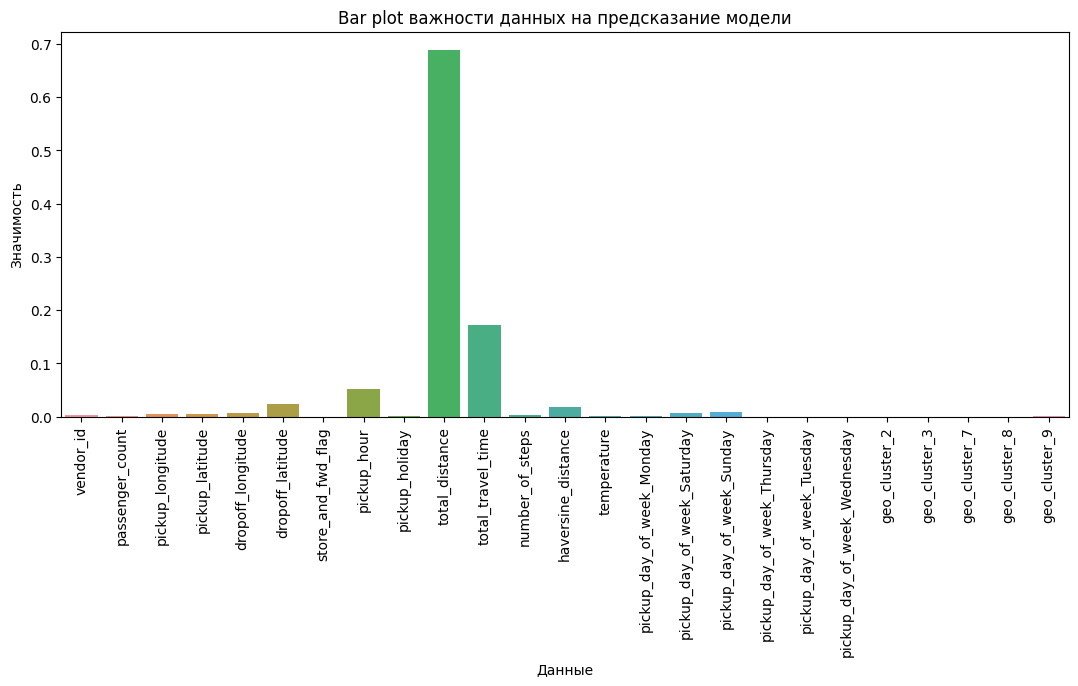

In [79]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_train.columns #признаки
feature_importances = rf_clf_taxi.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
feature_bar = sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
feature_bar.xaxis.set_tick_params(rotation=90)
ax.set_title('Bar plot важности данных на предсказание модели')
ax.set_xlabel('Данные')
ax.set_ylabel('Значимость');

### Задание 6.5.

* Несмотря на все преимущества, у метрики RMSLE есть один недостаток — она не является интерпретируемой. Нам хотелось бы понять, насколько наша итоговая модель хорошо предсказывает целевой признак с точки зрения бизнес-процесса. Точнее, мы бы хотели получить более понятное представление об ошибке прогноза длительности поездки.

Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Не забудьте перевести целевую переменную и предсказания вашей модели из логарифмического масштаба в изначальный, воспользовавшись формулой:$$y_i = exp(z_i) - 1$$
Значение метрики MeAE переведите в минуты и округлите до десятых.


### Перевод целевой переменной и предсказания модели из логарифмического масштаба в изначальный

In [157]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import median_absolute_error

gb = GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42,
    verbose=True
)

gb.fit(X_train, y_train_log)
y_valid_pred_gb = gb.predict(X_valid)
y_valid_pred = np.exp(y_valid_pred_gb) - 1
y_valid_real = np.exp(y_valid_log) - 1
MeAE = median_absolute_error(y_valid_real, y_valid_pred) / 60
print(f"MeAE on valid: {round(MeAE, 1)}")

      Iter       Train Loss   Remaining Time 
         1           0.3110           12.94m
         2           0.2250           12.62m
         3           0.1989           12.40m
         4           0.1883           12.23m
         5           0.1831           12.12m
         6           0.1785           11.98m
         7           0.1743           11.88m
         8           0.1724           11.78m
         9           0.1707           11.63m
        10           0.1678           11.53m
        20           0.1579           10.06m
        30           0.1532            8.76m
        40           0.1500            7.46m
        50           0.1467            6.14m
        60           0.1444            4.87m
        70           0.1426            3.62m
        80           0.1405            2.40m
        90           0.1386            1.20m
       100           0.1372            0.00s
MeAE on valid: 1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [158]:
test_data = pd.read_csv("data/Project5_test_data.csv")
osrm_data_test = pd.read_csv("data/Project5_osrm_data_test.csv")
test_id = test_data['id']

In [81]:
test_data = pd.read_csv("data/Project5_test_data.csv")

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [159]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)
# OneHot преобразование по обученной на trфin данных
X = test_data[['pickup_day_of_week', 'geo_cluster', 'events']]
test_data_onehot = one_hot.transform(X)
# Получаем закодированные имена столбцов
column_names = one_hot.get_feature_names_out()
# Преобразование sparse matrix of type '<class 'numpy.float64' полученной после OneHotEncoder в DF
test_data_onehot = pd.DataFrame(test_data_onehot.toarray(), columns=column_names)
# Добавление новой таблицы в старую с переиндексацией, с удалением исходных столбцов (которые кодировались)
test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(['pickup_day_of_week', 'geo_cluster', 'events'], axis=1), test_data_onehot], 
    axis=1
)


c:\Users\Major\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Отбор лучших скореллированных данных к целевой переменной
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)
 
best_features = selector.get_feature_names_out()
list(best_features)

In [161]:
# Создание списка столбцов которые надо удалить и удаление и выборок train и valid
columns_drop = []
for x in test_data.columns:
    if x not in list(best_features):
        columns_drop.append(x)
test_data.drop(columns_drop, axis=1, inplace=True)
print(f'Колонки test_date: {test_data.shape[1]}')

test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 1.0 if x == 'Y' else 0.0)

Колонки test_date: 25


In [169]:
y_test_predict = gb.predict(test_data)

In [170]:
y_test_predict

array([ 9.07961739,  9.07961739,  9.07961739, ..., 10.30446123,
       10.30446123, 10.30446123])

In [171]:
y_test_predict = np.exp(y_test_predict) - 1

In [172]:
y_test_predict

array([ 8773.6081084 ,  8773.6081084 ,  8773.6081084 , ...,
       29864.55908138, 29864.55908138, 29864.55908138])

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [173]:
# ваш код здесь
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)